# Workshop 9 - Introduction to Convolutional Neural Networks

Code for workshop 9.  This will use Keras (within tensorflow v2) to build a small CNN

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()

In [2]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


## Load data
We will use fashion MNIST, which is a set of small images (28x28) that contain 10 different fashion items - see below for class names and an example image.

In [3]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [4]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


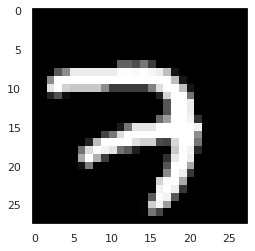

In [6]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

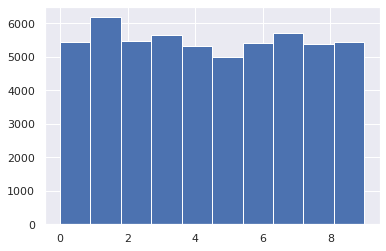

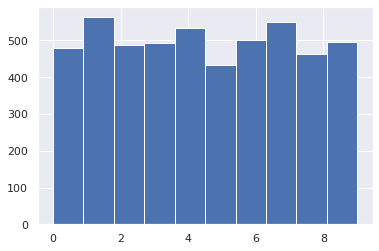

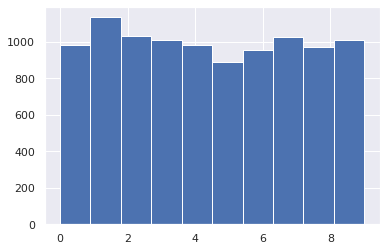

In [7]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [8]:
# Some key parameters
n_train = 3000
n_valid = 1000
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
actfn = "relu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [9]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

In [10]:
# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by replacing the Flatten and Dense lines with
#   model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate a single output per filter 
#  which requires the convolution to be "valid" and not "same"

In [11]:
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

In [12]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [13]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True) 

In [14]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size):
    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb],
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history, model)

In [16]:
valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)

Epoch 1/20
94/94 [==============================] - 0s 3ms/step - loss: 2.2585 - accuracy: 0.1697 - val_loss: 2.1948 - val_accuracy: 0.2000
Epoch 2/20
94/94 [==============================] - 0s 2ms/step - loss: 1.9968 - accuracy: 0.4060 - val_loss: 1.6080 - val_accuracy: 0.6200
Epoch 3/20
94/94 [==============================] - 0s 2ms/step - loss: 1.0628 - accuracy: 0.6987 - val_loss: 0.7274 - val_accuracy: 0.7850
Epoch 4/20
94/94 [==============================] - 0s 2ms/step - loss: 0.6152 - accuracy: 0.8013 - val_loss: 0.5861 - val_accuracy: 0.8160
Epoch 5/20
94/94 [==============================] - 0s 2ms/step - loss: 0.4843 - accuracy: 0.8417 - val_loss: 0.4967 - val_accuracy: 0.8580
Epoch 6/20
94/94 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.8653 - val_loss: 0.4729 - val_accuracy: 0.8560
Epoch 7/20
94/94 [==============================] - 0s 2ms/step - loss: 0.3694 - accuracy: 0.8830 - val_loss: 0.4629 - val_accuracy: 0.8700
Epoch 8/20
94/94 [==

In [17]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[7 2 1]
['7' '2' '1']
['7' '2' '1']


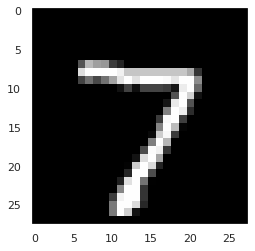

In [18]:
# We can inspect the output class predictions
y_pred = model.predict_classes(X_test[:3])  # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [19]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.2313007265329361, 0.9326000213623047]


In [20]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

[[0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]]


# Exploring parameters

For example, why make these particular choices for architecture and parameters.

Let us systematically vary one parameter at a time.

In [21]:
# Learning rate
res=[]
for lr in [100, 10, 1, 0.1]:
    valacc, testacc, history = do_all(hiddensizes, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[lr*learningrate,valacc,testacc]]
print(res)

Epoch 1/20
94/94 [==============================] - 0s 3ms/step - loss: 2.3097 - accuracy: 0.1157 - val_loss: 2.3132 - val_accuracy: 0.1000
Epoch 2/20
94/94 [==============================] - 0s 2ms/step - loss: 2.3084 - accuracy: 0.1133 - val_loss: 2.3147 - val_accuracy: 0.0930
Epoch 3/20
94/94 [==============================] - 0s 2ms/step - loss: 2.3062 - accuracy: 0.1090 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 4/20
94/94 [==============================] - 0s 2ms/step - loss: 2.3100 - accuracy: 0.0963 - val_loss: 2.3062 - val_accuracy: 0.0970


ValueError: too many values to unpack (expected 3)

In [22]:
# Number of layers
res=[]
for n in [1, 2, 3]:
    valacc, testacc, history = do_all(hiddensizes[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[n,valacc,testacc]]
print(res)

Epoch 1/20
94/94 [==============================] - 2s 16ms/step - loss: 2.1164 - accuracy: 0.3863 - val_loss: 1.6802 - val_accuracy: 0.6530
Epoch 2/20
94/94 [==============================] - 0s 2ms/step - loss: 0.9837 - accuracy: 0.7450 - val_loss: 0.6345 - val_accuracy: 0.8120
Epoch 3/20
94/94 [==============================] - 0s 2ms/step - loss: 0.5276 - accuracy: 0.8330 - val_loss: 0.5228 - val_accuracy: 0.8520
Epoch 4/20
94/94 [==============================] - 0s 2ms/step - loss: 0.4387 - accuracy: 0.8680 - val_loss: 0.4760 - val_accuracy: 0.8480
Epoch 5/20
94/94 [==============================] - 0s 2ms/step - loss: 0.4004 - accuracy: 0.8720 - val_loss: 0.4432 - val_accuracy: 0.8680
Epoch 6/20
94/94 [==============================] - 0s 2ms/step - loss: 0.3618 - accuracy: 0.8863 - val_loss: 0.4251 - val_accuracy: 0.8770
Epoch 7/20
94/94 [==============================] - 0s 2ms/step - loss: 0.3359 - accuracy: 0.8930 - val_loss: 0.4320 - val_accuracy: 0.8820
Epoch 8/20
94/94 [=

ValueError: too many values to unpack (expected 3)

In [21]:
# Training set size
res=[]
for ntr in [n_train*0.01, n_train*0.1, n_train*0.5, n_train]:
    valacc, testacc, history = do_all(hiddensizes, actfn, optimizer, learningrate, int(ntr), n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[int(ntr),valacc,testacc]]
print(res)

Train on 30 samples, validate on 1000 samples
Epoch 1/20
30/30 [==============================] - 0s 11ms/sample - loss: 2.2915 - accuracy: 0.1000 - val_loss: 2.3077 - val_accuracy: 0.1070
Epoch 2/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.2901 - accuracy: 0.1000 - val_loss: 2.3073 - val_accuracy: 0.1080
Epoch 3/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.2886 - accuracy: 0.1000 - val_loss: 2.3070 - val_accuracy: 0.1090
Epoch 4/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.2871 - accuracy: 0.1000 - val_loss: 2.3067 - val_accuracy: 0.1110
Epoch 5/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.2857 - accuracy: 0.1000 - val_loss: 2.3064 - val_accuracy: 0.1120
Epoch 6/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.2842 - accuracy: 0.1000 - val_loss: 2.3060 - val_accuracy: 0.1120
Epoch 7/20
30/30 [==============================] - 0s 2ms/sample - loss: 2.2828 - accuracy: 0.1000 -

ValueError: too many values to unpack (expected 3)

In [23]:
# Plot results (test accuracy vs factor that is changing)
res=np.array(res)
plt.plot(res[:,0],res[:,2],'-o')
plt.show()

IndexError: too many indices for array